In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, v_backtester, c_backtester, perf, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 60
periods = 100
multi_periods = [25, 50, 100]
multiplier = 20
threshold = 1
bankroll = 15000
smooth = int(np.ceil(periods/4))

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
#contract = contract.loc['20180202':]
contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180228']
#contract = contract.loc['20181001':'20181231']

In [4]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

20106.432487490358

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2019-04-01 02:55:00,7430.00,7472.50,7428.50,7465.50,11834,20082
1,2019-04-01 07:25:00,7465.25,7487.50,7463.25,7476.75,12701,20138
2,2019-04-01 10:29:00,7476.75,7484.25,7469.25,7482.25,11581,19926
3,2019-04-01 13:22:00,7482.50,7487.50,7465.50,7470.75,11667,20336
4,2019-04-01 15:28:00,7471.25,7476.75,7460.50,7472.00,11333,20146
...,...,...,...,...,...,...,...
2446,2019-09-04 16:13:00,7686.00,7693.75,7665.50,7670.50,10940,20463
2447,2019-09-04 16:38:00,7670.25,7683.75,7665.75,7681.50,10663,20976
2448,2019-09-04 17:12:00,7681.25,7686.75,7673.00,7683.00,10486,20499


In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
data['change'] = data.close.diff().fillna(0)
data['up'] = (data['change'] > 0) * data['change']
data['down'] = ((data['change'] < 0) * data['change']).abs()
data

,date,open,close,change,up,down
label,,,,,,
0,2019-04-01 02:55:00,7430.00,7465.50,0.00,0.00,0.0
1,2019-04-01 07:25:00,7465.25,7476.75,11.25,11.25,0.0
2,2019-04-01 10:29:00,7476.75,7482.25,5.50,5.50,0.0
3,2019-04-01 13:22:00,7482.50,7470.75,-11.50,-0.00,11.5
4,2019-04-01 15:28:00,7471.25,7472.00,1.25,1.25,0.0
...,...,...,...,...,...,...
2446,2019-09-04 16:13:00,7686.00,7670.50,-15.50,-0.00,15.5
2447,2019-09-04 16:38:00,7670.25,7681.50,11.00,11.00,0.0
2448,2019-09-04 17:12:00,7681.25,7683.00,1.50,1.50,0.0


In [8]:
data['rs'] = data['up'].ewm(span=periods, min_periods=periods*.9).mean() / data['down'].ewm(span=periods, min_periods=periods*.9).mean()
data['rsi'] = (100 - (100 / (1 + data['rs'])))
data['rsi_mod'] = data['rsi'] - 50
data['rsi_mod'] *= -1.3
data['rsi_mod'] = data['rsi_mod'].clip(lower=-20, upper=20)
data

,date,open,close,change,up,down,rs,rsi,rsi_mod
label,,,,,,,,,
0,2019-04-01 02:55:00,7430.00,7465.50,0.00,0.00,0.0,NaN,NaN,NaN
1,2019-04-01 07:25:00,7465.25,7476.75,11.25,11.25,0.0,NaN,NaN,NaN
2,2019-04-01 10:29:00,7476.75,7482.25,5.50,5.50,0.0,NaN,NaN,NaN
3,2019-04-01 13:22:00,7482.50,7470.75,-11.50,-0.00,11.5,NaN,NaN,NaN
4,2019-04-01 15:28:00,7471.25,7472.00,1.25,1.25,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2446,2019-09-04 16:13:00,7686.00,7670.50,-15.50,-0.00,15.5,1.061672,51.495685,-1.944391
2447,2019-09-04 16:38:00,7670.25,7681.50,11.00,11.00,0.0,1.091606,52.189841,-2.846793
2448,2019-09-04 17:12:00,7681.25,7683.00,1.50,1.50,0.0,1.095770,52.284840,-2.970291


In [9]:
10/data['rsi_mod'].abs().mean()

1.4118574121291168

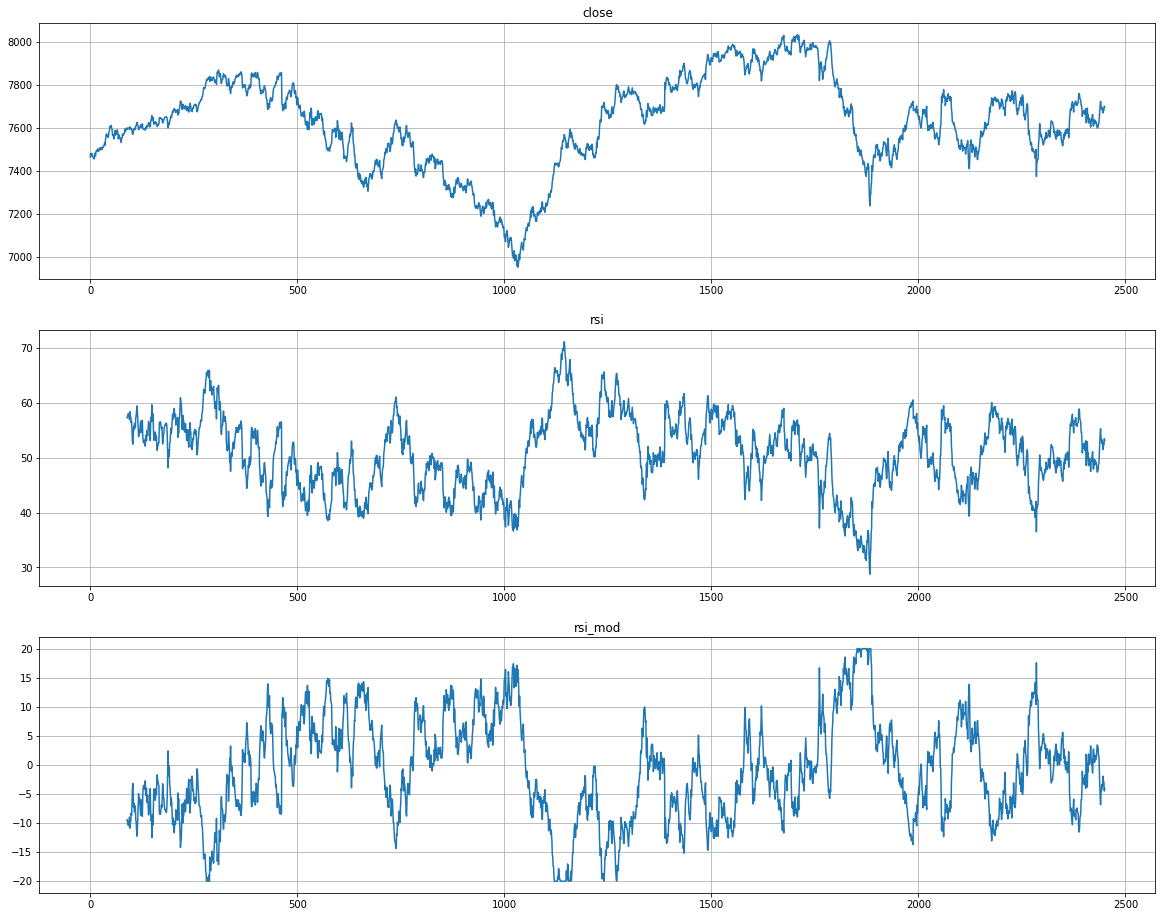

In [10]:
plot(data[['close', 'rsi', 'rsi_mod']])

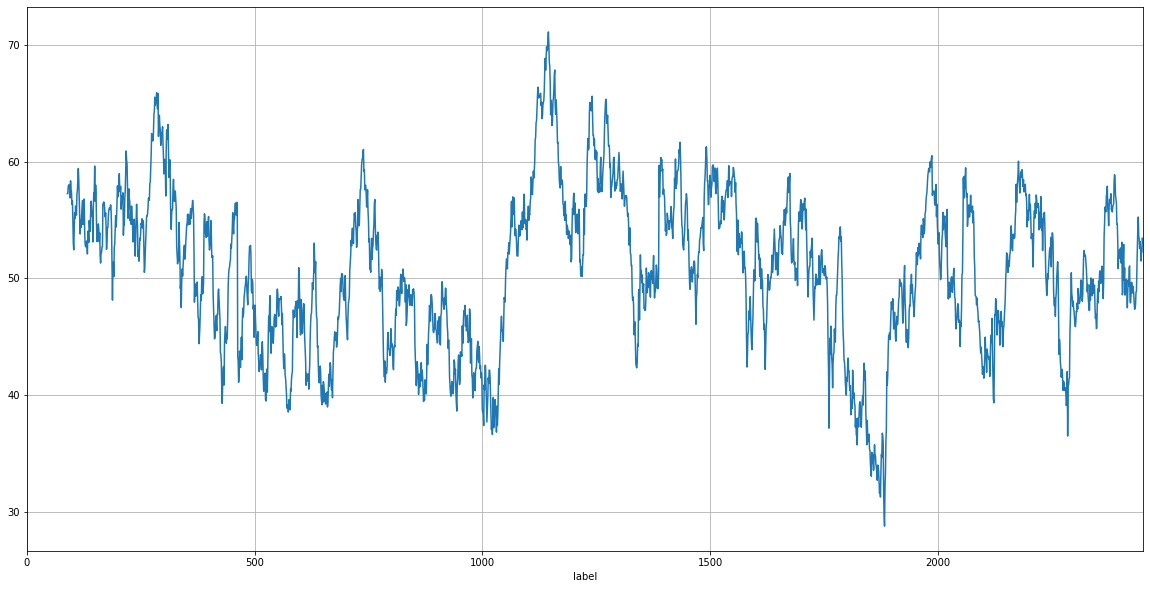

In [11]:
data['rsi'].plot(figsize=(20,10), grid=True);

In [12]:
data['rsi_shift'] = (data['rsi'] - 50) / 20
data

,date,open,close,change,up,down,rs,rsi,rsi_mod,rsi_shift
label,,,,,,,,,,
0,2019-04-01 02:55:00,7430.00,7465.50,0.00,0.00,0.0,NaN,NaN,NaN,NaN
1,2019-04-01 07:25:00,7465.25,7476.75,11.25,11.25,0.0,NaN,NaN,NaN,NaN
2,2019-04-01 10:29:00,7476.75,7482.25,5.50,5.50,0.0,NaN,NaN,NaN,NaN
3,2019-04-01 13:22:00,7482.50,7470.75,-11.50,-0.00,11.5,NaN,NaN,NaN,NaN
4,2019-04-01 15:28:00,7471.25,7472.00,1.25,1.25,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2446,2019-09-04 16:13:00,7686.00,7670.50,-15.50,-0.00,15.5,1.061672,51.495685,-1.944391,0.074784
2447,2019-09-04 16:38:00,7670.25,7681.50,11.00,11.00,0.0,1.091606,52.189841,-2.846793,0.109492
2448,2019-09-04 17:12:00,7681.25,7683.00,1.50,1.50,0.0,1.095770,52.284840,-2.970291,0.114242


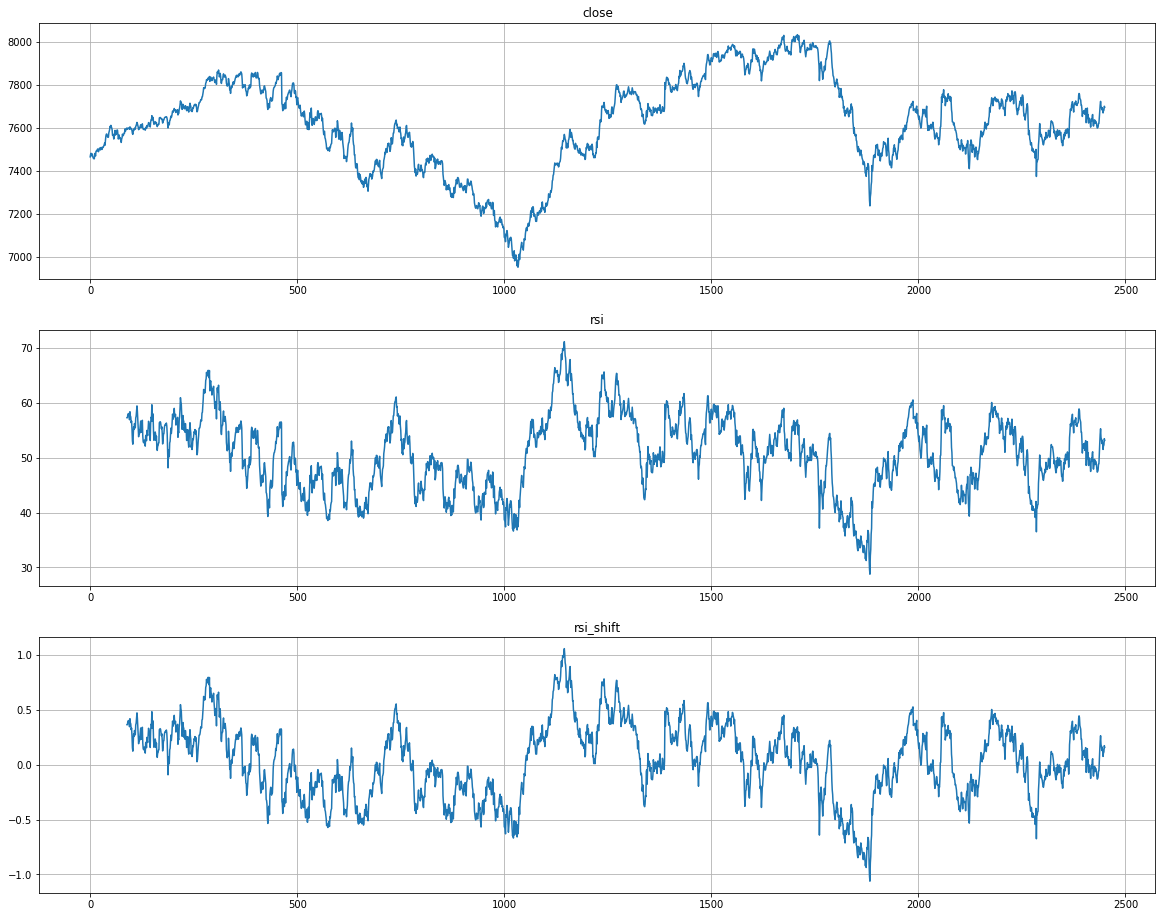

In [13]:
plot(data[['close', 'rsi', 'rsi_shift']])

In [14]:
data['rsi_shift'].abs().mean()

0.2745364577583761

In [15]:
data['rsi_trans'] = np.sin(data['rsi_shift'] * np.pi)
data['trans_smooth'] = data['rsi_trans'].ewm(span=10).mean()
data.tail(20)

,date,open,close,change,up,down,rs,rsi,rsi_mod,rsi_shift,rsi_trans,trans_smooth
label,,,,,,,,,,,,
2431,2019-09-03 19:31:00,7622.00,7608.75,-13.50,-0.00,13.50,0.919640,47.906907,2.721021,-0.104655,-0.322891,-0.170969
2432,2019-09-03 20:03:00,7608.50,7599.75,-9.00,-0.00,9.00,0.899754,47.361606,3.429912,-0.131920,-0.402675,-0.213098
2433,2019-09-03 20:38:00,7599.75,7601.50,1.75,1.75,0.00,0.904044,47.480195,3.275747,-0.125990,-0.385556,-0.244454
2434,2019-09-03 21:19:00,7601.25,7605.25,3.75,3.75,0.00,0.913421,47.737595,2.941126,-0.113120,-0.347945,-0.263270
2435,2019-09-03 21:53:00,7605.50,7621.25,16.00,16.00,0.00,0.954241,48.829243,1.521985,-0.058538,-0.182867,-0.248651
2436,2019-09-04 00:46:00,7621.25,7622.00,0.75,0.75,0.00,0.956193,48.880306,1.455602,-0.055985,-0.174976,-0.235256
2437,2019-09-04 03:34:00,7622.00,7652.75,30.75,30.75,0.00,1.037846,50.928569,-1.207139,0.046428,0.145343,-0.166056
2438,2019-09-04 06:59:00,7652.50,7680.50,27.75,27.75,0.00,1.113020,52.674382,-3.476697,0.133719,0.407843,-0.061711
2439,2019-09-04 08:45:00,7681.00,7707.50,27.00,27.00,0.00,1.187641,54.288666,-5.575266,0.214433,0.623852,0.062937


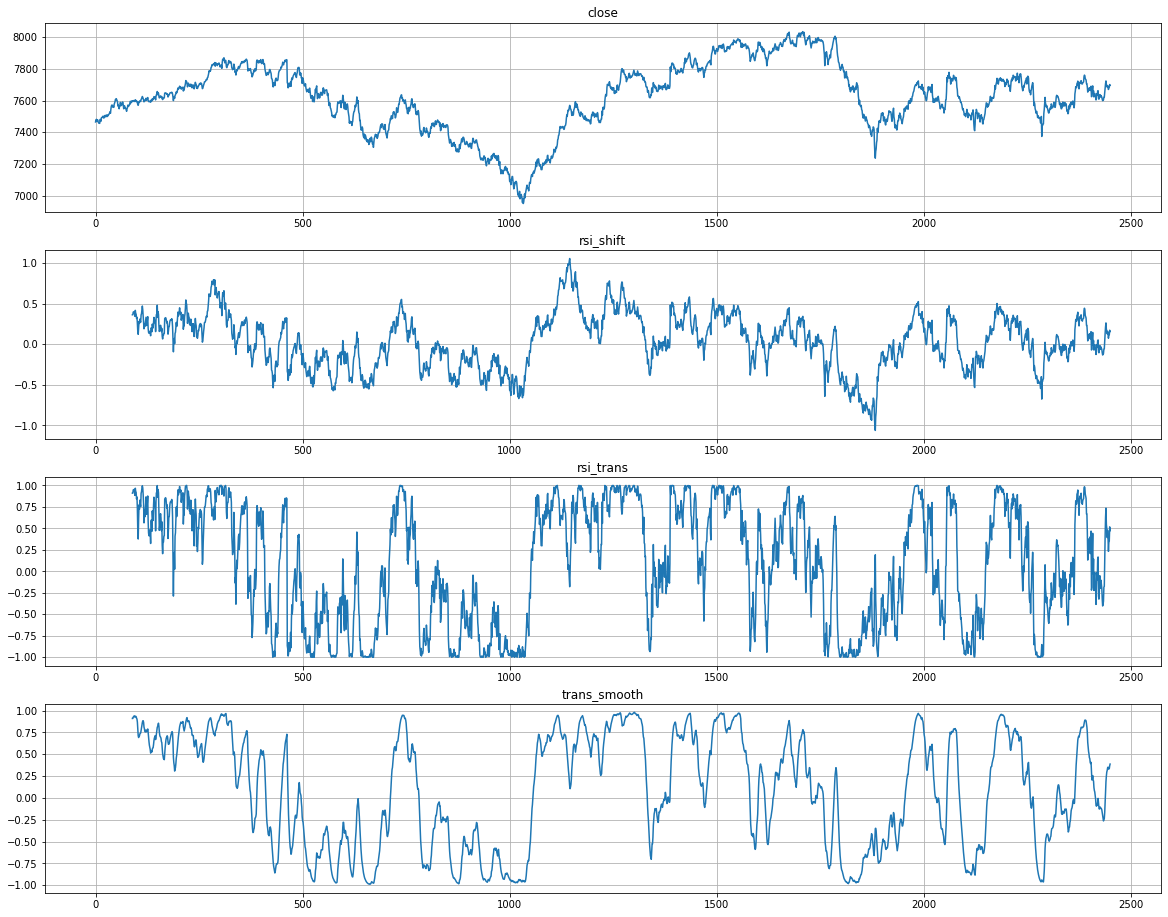

In [16]:
plot(data['close'], data['rsi_shift'], data['rsi_trans'], data['trans_smooth'])

In [17]:
data[['close', 'rsi', 'rsi_shift', 'rsi_trans']].loc[43:].head(30)

,close,rsi,rsi_shift,rsi_trans
label,,,,
43,7562.50,NaN,NaN,NaN
44,7557.50,NaN,NaN,NaN
45,7577.00,NaN,NaN,NaN
46,7585.25,NaN,NaN,NaN
47,7593.00,NaN,NaN,NaN
48,7607.75,NaN,NaN,NaN
49,7605.25,NaN,NaN,NaN
50,7612.50,NaN,NaN,NaN
51,7606.75,NaN,NaN,NaN


In [18]:
signal = pd.DataFrame({'close': data.close,
                     'rsi': data.rsi})
signal = signal.loc[45:]
signal

,close,rsi
label,,
45,7577.00,NaN
46,7585.25,NaN
47,7593.00,NaN
48,7607.75,NaN
49,7605.25,NaN
...,...,...
2446,7670.50,51.495685
2447,7681.50,52.189841
2448,7683.00,52.284840


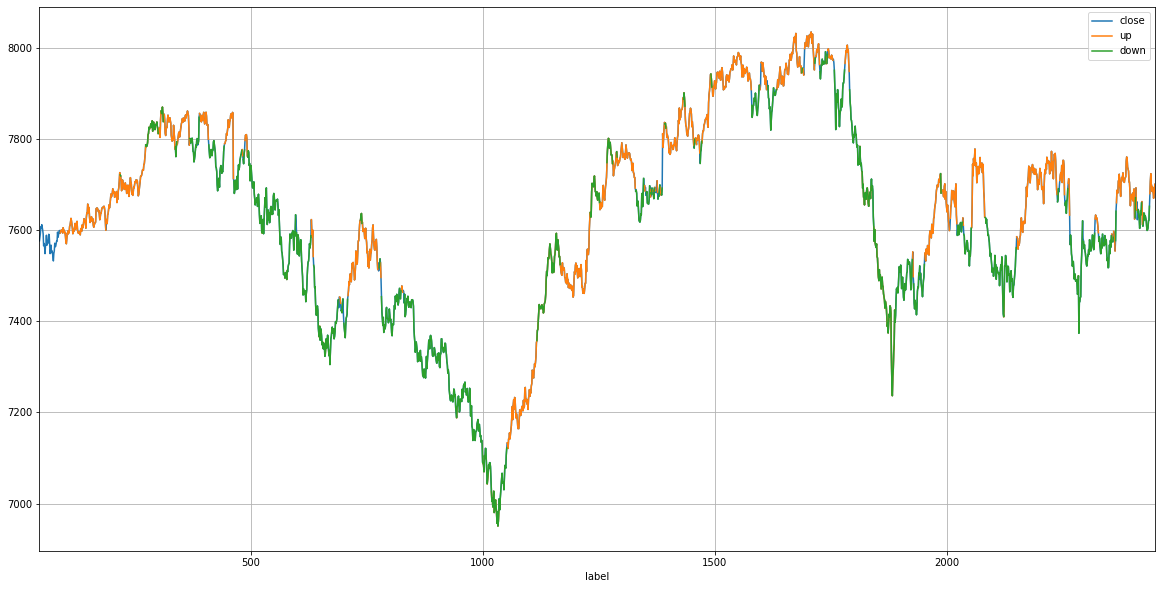

In [19]:
signal['up'] = ((signal['rsi'] > 50) | (signal['rsi'] < 40)).shift() * signal['close']
signal['down'] = ((signal['rsi'] < 50) | (signal['rsi']> 60)).shift() * signal['close']
signal['up'] = signal['up'].replace(0, np.nan)
signal['down'] = signal['down'].replace(0, np.nan)
signal[['close', 'up', 'down']].plot(figsize=(20,10), grid=True);

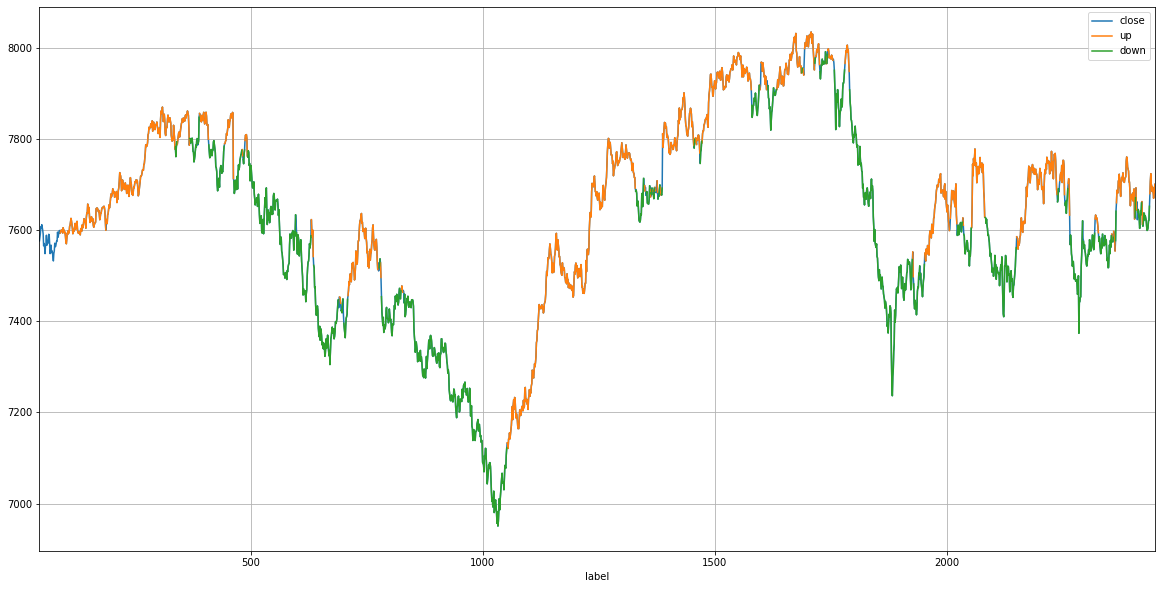

In [20]:
signal['up'] = ((signal['rsi'] > 50)).shift() * signal['close']
signal['down'] = ((signal['rsi'] < 50)).shift() * signal['close']
signal['up'] = signal['up'].replace(0, np.nan)
signal['down'] = signal['down'].replace(0, np.nan)
signal[['close', 'up', 'down']].plot(figsize=(20,10), grid=True);

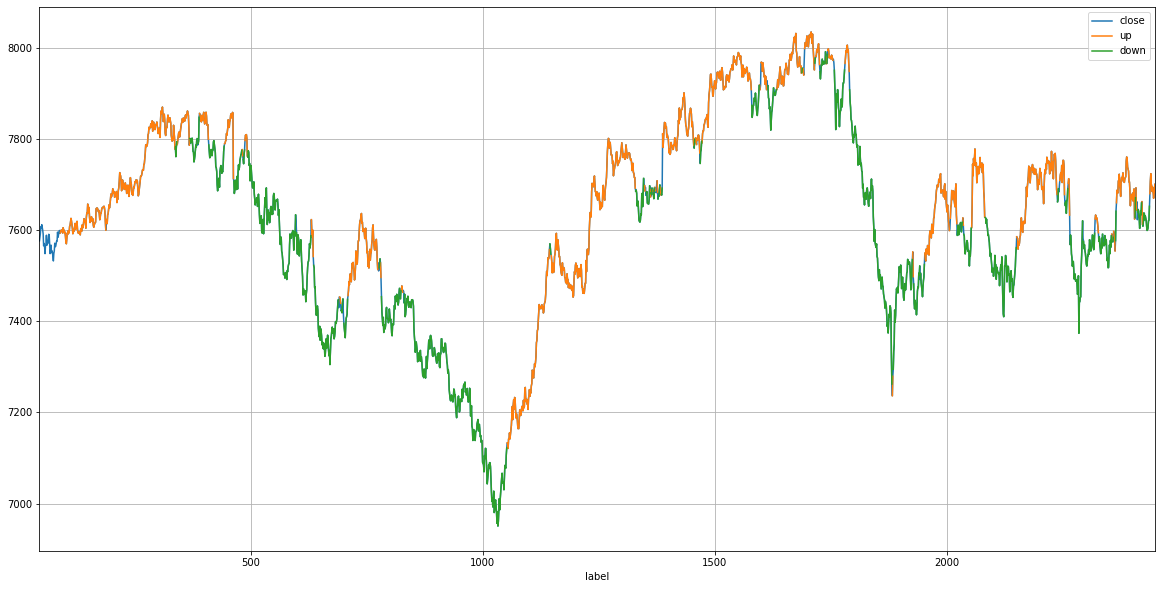

In [21]:
signal_1 = pd.DataFrame({'close': data.close,
                         'rsi_trans': data.rsi_trans})
signal_1 = signal_1.loc[45:]
signal_1['up'] = ((signal_1['rsi_trans'] > 0)).shift() * signal_1['close']
signal_1['down'] = ((signal_1['rsi_trans'] < 0)).shift() * signal_1['close']
signal_1['up'] = signal_1['up'].replace(0, np.nan)
signal_1['down'] = signal_1['down'].replace(0, np.nan)
signal_1[['close', 'up', 'down']].plot(figsize=(20,10), grid=True);

In [22]:
test_data = data[['date', 'close', 'rsi']]

In [23]:
test_data['signal_up'] = (test_data['rsi'] >= 50) * 1
test_data['signal_down'] = (test_data['rsi'] < 50) * -1
test_data['signal'] = test_data['signal_up'] + test_data['signal_down']
test_data = test_data.iloc[50:]
test_data['position'] = test_data['signal'].shift().fillna(0)
test_data.tail()

,date,close,rsi,signal_up,signal_down,signal,position
label,,,,,,,
2446,2019-09-04 16:13:00,7670.50,51.495685,1,0,1,1.0
2447,2019-09-04 16:38:00,7681.50,52.189841,1,0,1,1.0
2448,2019-09-04 17:12:00,7683.00,52.284840,1,0,1,1.0
2449,2019-09-04 17:44:00,7701.75,53.464026,1,0,1,1.0
2450,2019-09-04 18:31:00,7697.25,53.142464,1,0,1,1.0


Annual return                 -0.124963
Cumulative returns           -0.0576026
Annual volatility              0.160294
Sharpe ratio                  -0.753139
Calmar ratio                   -0.90013
Stability                     0.0413564
Max drawdown                  -0.138827
Omega ratio                    0.882808
Sortino ratio                  -1.04916
Skew                            0.12913
Kurtosis                        1.45299
Tail ratio                      1.02172
Daily value at risk          -0.0206742
Win percent                    0.305344
Average gain                    58.2875
Average loss                   -30.4396
Avg gain/loss ratio             1.91486
Position EV                    -3.34733
Positions per day               1.16964
Days per position              0.854962
Actual avg. duration    1 days 03:52:00
Days                                112
Positions                           131
Trades                              261


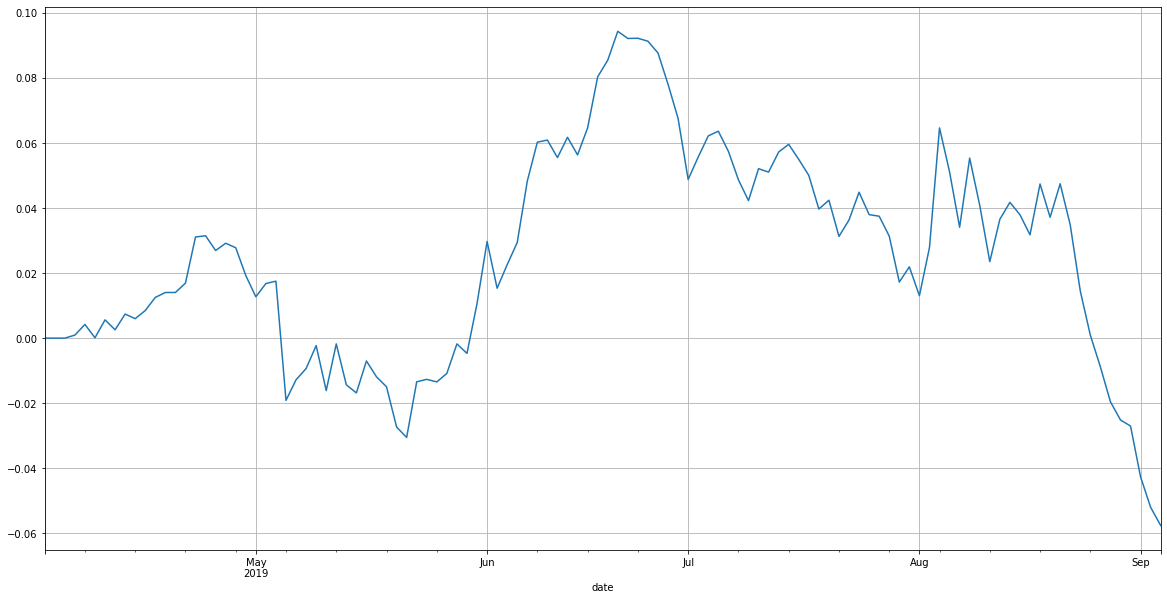

In [24]:
result = perf_var(test_data.set_index('date')[['close', 'position']], price_column_name='close')

In [25]:
result.df.head(20)

,price,position,transaction,curr_price,base_price,pnl
date,,,,,,
2019-04-03 17:56:00,7612.50,0.0,0,0.0,0.0,0.0
2019-04-03 18:29:00,7606.75,0.0,0,0.0,0.0,0.0
2019-04-03 19:04:00,7600.50,0.0,0,0.0,0.0,0.0
2019-04-03 19:39:00,7592.25,0.0,0,0.0,0.0,0.0
2019-04-03 19:58:00,7566.00,0.0,0,0.0,0.0,0.0
2019-04-03 20:20:00,7571.25,0.0,0,0.0,0.0,0.0
2019-04-03 20:52:00,7564.75,0.0,0,0.0,0.0,0.0
2019-04-03 21:19:00,7548.75,0.0,0,0.0,0.0,0.0
2019-04-03 21:44:00,7565.75,0.0,0,0.0,0.0,0.0


In [31]:
result.positions.tail(20)

,date_o,open,date_c,close,pnl,duration
111,2019-08-23 17:09:00,-7569.00,2019-08-26 12:18:00,7582.75,-13.75,2 days 19:09:00
112,2019-08-26 12:18:00,7582.75,2019-08-26 13:36:00,-7575.75,-7.00,0 days 01:18:00
113,2019-08-26 13:36:00,-7575.75,2019-08-27 14:30:00,7624.75,-49.00,1 days 00:54:00
114,2019-08-27 14:30:00,7624.75,2019-08-27 17:26:00,-7576.25,-48.50,0 days 02:56:00
115,2019-08-27 17:26:00,-7576.25,2019-08-27 21:29:00,7571.50,4.75,0 days 04:03:00
116,2019-08-27 21:29:00,7571.50,2019-08-27 21:54:00,-7571.00,-0.50,0 days 00:25:00
117,2019-08-27 21:54:00,-7571.00,2019-08-28 17:57:00,7591.75,-20.75,0 days 20:03:00
118,2019-08-28 17:57:00,7591.75,2019-08-28 19:31:00,-7574.75,-17.00,0 days 01:34:00
119,2019-08-28 19:31:00,-7574.75,2019-08-28 21:18:00,7597.75,-23.00,0 days 01:47:00
120,2019-08-28 21:18:00,7597.75,2019-08-29 08:27:00,-7577.50,-20.25,0 days 11:09:00


In [26]:
a = pd.DataFrame({'x': np.arange(-4,4, .1),})
a['y'] = (1/(1+np.exp(-a['x'])))
a['z'] = (a['x'] / (1+a['x']**2)**.5)

In [27]:
a.set_index('x', inplace=True)

In [28]:
a

,y,z
x,,
-4.0,0.017986,-0.970143
-3.9,0.019840,-0.968664
-3.8,0.021881,-0.967075
-3.7,0.024127,-0.965363
-3.6,0.026597,-0.963518
...,...,...
3.5,0.970688,0.961524
3.6,0.973403,0.963518
3.7,0.975873,0.965363


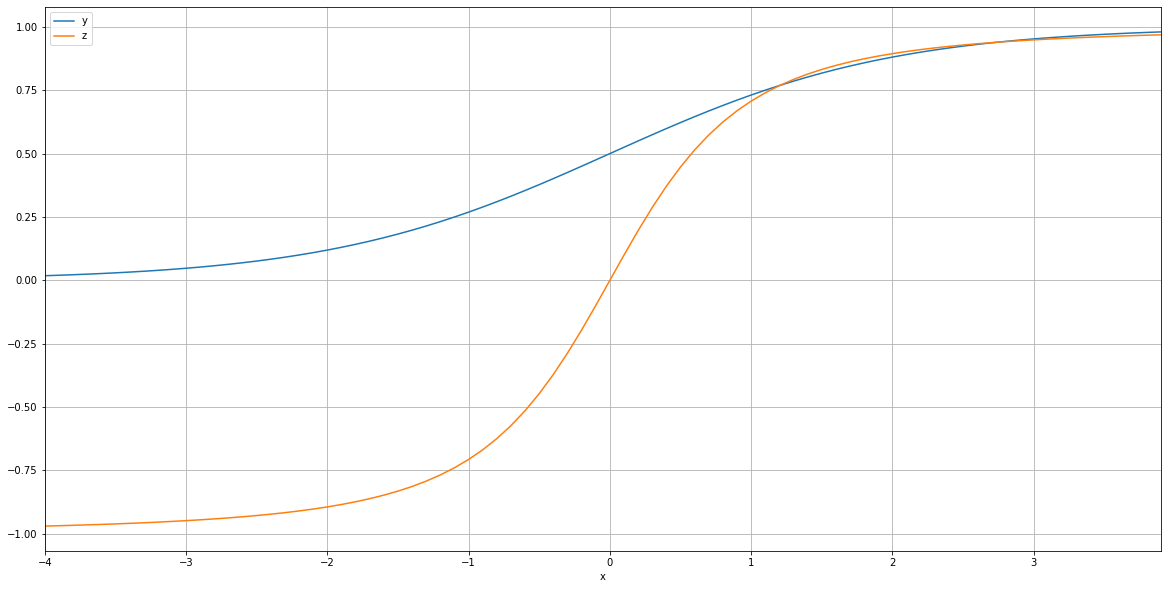

In [29]:
a.plot(figsize=(20,10), grid=True);